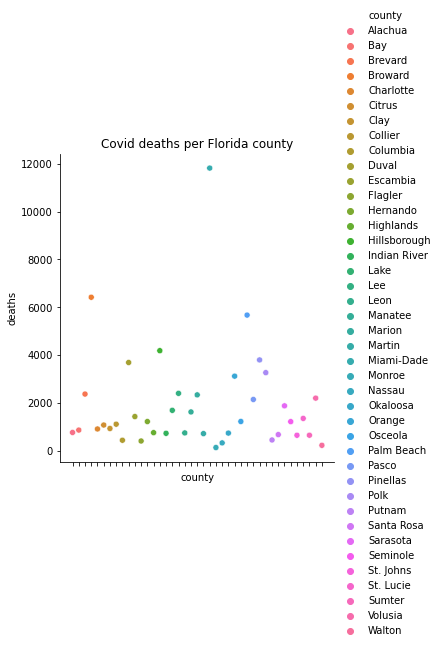

In [84]:


import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

covid_data=pd.read_csv("us-counties-recent.csv");

newdata=covid_data[covid_data["state"]=="Florida"];

agedata=pd.read_csv("cc-est2019-agesex-12.csv");
newdata2=agedata[agedata["YEAR"]==12];

educ_data=pd.read_csv("ACSST1Y2021.S1501-2022-10-17T192910.csv");

eddat=[];
columnsdat=[i for i in range(1,len(list(educ_data.columns)),12)];
columnsdat.insert(0,0)


eddat2=educ_data[educ_data.columns[columnsdat]]
eddat2.columns = eddat2.columns.str.replace('County, Florida!!Total!!Estimate','')

#print(list(newdata[newdata['county']=="Baker"].index))
for j in newdata["county"]:
    k=j+' '   
    b=list(newdata[newdata['county']==j].index)
    if k not in list(eddat2.columns):
        newdata=newdata.drop(b)

# print(newdata)
#print(len(newdata))
#print(newdata.iloc[(1230-41):1231,5])

cumuldeaths=newdata.iloc[(1230-41):1231,5]

# print(cumuldeaths)

newcovdata=newdata[newdata["deaths"]>=1000];
sns.relplot(data=cumuldeaths, x=newdata.iloc[(1230-41):1231,1], y=cumuldeaths, hue=newdata.iloc[(1230-41):1231,1]).set(xticklabels=[],title='Covid deaths per Florida county')


In [3]:
newcovdata=cumuldeaths>1000
sns.relplot(data=newcovdata["deaths"], x=newcovdata["county"], y=newcovdata["deaths"], hue=newcovdata["county"], size=newcovdata["deaths"],sizes=(10, 100)).set(xticklabels=[], title="Florida Counties with covid deaths over 1000")


NameError: name 'newcovdata' is not defined

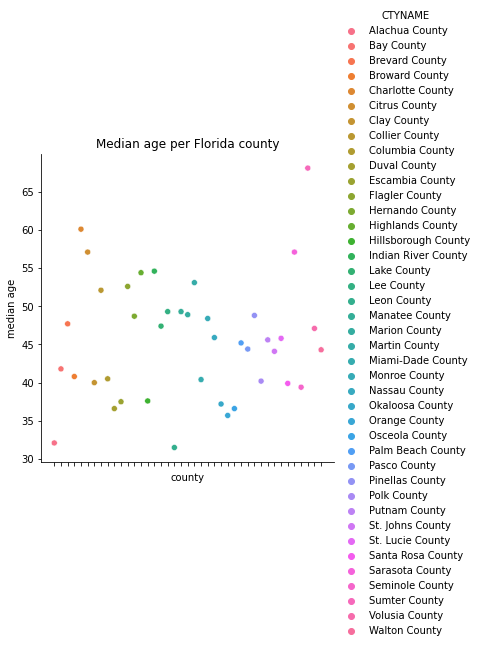

In [88]:
#median age used for the sake of plotting the data. gives an idea of the counties with older population  

agedata2=[];



columnsdat2=[i for i in range(39,len(list(newdata2.columns)),3)];
columnsdat2.insert(0,9)
columnsdat2.insert(0,6)
columnsdat2.insert(0,4)


agedata2=newdata2[newdata2.columns[columnsdat2]]

for j in agedata2["CTYNAME"]:
    k=j.replace('County','')  
    b=list(agedata2[agedata2['CTYNAME']==j].index)
    if k not in list(eddat2.columns):
        agedata2=agedata2.drop(b)
# print(agedata2)

sns.relplot(data=agedata2["MEDIAN_AGE_TOT"], x=agedata2["CTYNAME"], y=agedata2["MEDIAN_AGE_TOT"], hue=agedata2["CTYNAME"]).set(xticklabels=[],title='Median age per Florida county',xlabel="county",ylabel="median age")



0.9999999999999999


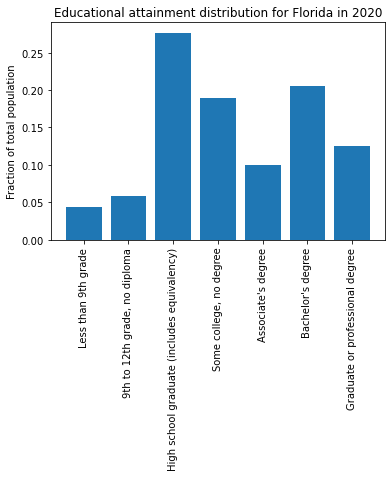

In [111]:
#Education data - looking at the 5 categories 
#normalized to the total population 

tot_pop=int(eddat2.iloc[6,-1].replace(",",""));
fracpop=[int(i.replace(",",""))/tot_pop for i in eddat2.iloc[7:14,-1]]
# print(fracpop)

plt.bar(eddat2.iloc[7:14,0], fracpop)
plt.xticks(rotation=90)
plt.ylabel("Fraction of total population")
plt.title("Educational attainment distribution for Florida in 2020")




maxdeath=np.max(newdata["deaths"])

mindeath=np.min(cumuldeaths)   
# print(mindeath)

max_ind=newdata[newdata['deaths']==maxdeath].index
min_ind=newdata[newdata['deaths']==mindeath].index
countymax=newdata.loc[max_ind[-1]].at["county"]
countymin=newdata.loc[min_ind[-1]].at["county"]
   
# print(eddat2[countymax+' '])
# print(eddat2[countymin+' '])

md_eddat=[int(eddat2[countymax+' '][i].replace(",",""))/int(eddat2[countymax+' '][6].replace(",","")) for i in range(7,14)]
# print(md_eddat)
mon_eddat=[int(eddat2[countymin+' '][i].replace(",",""))/int(eddat2[countymin+' '][6].replace(",","")) for i in range(7,14)]
print(sum(mon_eddat))

Text(0.5, 1.0, 'Null distribution of U1 for n=7')

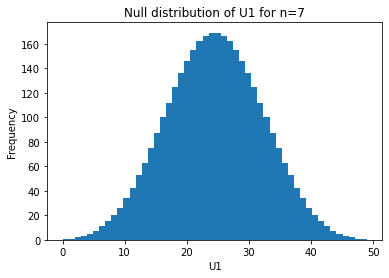

In [130]:

import itertools 

r=len(md_eddat); #number of samples in each group equal to the length of the data for miami dade county 
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats for a length of 10 
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than 5 but for this there can only be 5 repeats
#per combination so this returns a list of the combinations that only have 5 repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=50); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for n='+str(len(md_eddat)))

In [113]:
#finding whether the following vectors come from the same distribution using the u statistic 

#vectors with the sample values 

from scipy import stats 

u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(md_eddat)): #for loop iterating over the length of a 
    wins=[1 for x in range(0,len(md_eddat)) if mon_eddat[i]>md_eddat[x]]; #loops over all elements of b if the element in a is greater than
    #the element in b then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in a to the list u 

u1=sum(u) #sums up the total number of wins for a over b to get u1 
u2=(len(md_eddat)*len(mon_eddat))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 (a-b) is",u1,'and U2 is',u2) 
print("the likelihood of a and b being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(mon_eddat,md_eddat)[0],"U2=",stats.mannwhitneyu(md_eddat,mon_eddat)[0],"and p is",stats.mannwhitneyu(mon_eddat,md_eddat)[1])



U1 (a-b) is 23 and U2 is 26
the likelihood of a and b being from the same distribution is 0.9015151515151515
U and p values from the stats package. U1= 23.0 U2= 26.0 and p is 0.9015151515151516


In [116]:
# print(list(newdata2[newdata2['CTYNAME']=="Miami-Dade County"].index))

# print(agedata2[agedata2['CTYNAME']=="Miami-Dade County"])

mdage=[(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,i]+agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,i+1])/agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,1] for i in range(3,len(list(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].columns))-2,2)]
# print(mdage)
monage= [(agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,i]+agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,i+1])/agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,1] for i in range(3,len(list(agedata2[agedata2['CTYNAME']=="Monroe County"].columns))-2,2)]
# print(sum(monage))




1.0


Text(0.5, 1.0, 'Null distribution of U1 for a sample of 5 per group ')

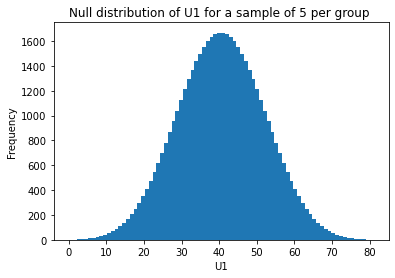

In [12]:
r=len(mdage); #number of samples in each group
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats for a length of 10 
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than 5 but for this there can only be 5 repeats
#per combination so this returns a list of the combinations that only have 5 repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=80); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for n= '+str(len(mda)))

In [118]:
u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(mdage)): #for loop iterating over the length of a 
    wins=[1 for x in range(0,len(monage)) if monage[i]>mdage[x]]; #loops over all elements of b if the element in a is greater than
    #the element in b then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in a to the list u 

u1=sum(u) #sums up the total number of wins for a over b to get u1 
u2=(len(mdage)*len(monage))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 (a-b) is",u1,'and U2 is',u2) 
print("the likelihood of a and b being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(monage,mdage)[0],"U2=",stats.mannwhitneyu(mdage,monage)[0],"and p is",stats.mannwhitneyu(mdage,monage)[1])


U1 (a-b) is 39 and U2 is 42
the likelihood of a and b being from the same distribution is 0.9865967365967366
U and p values from the stats package. U1= 39.0 U2= 42.0 and p is 0.9296365245070707


<AxesSubplot:ylabel='Count'>

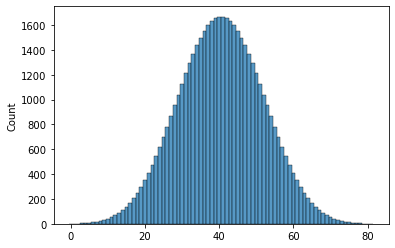

In [8]:
# Set sample size, asssuming an equal # of samples from both groups
n = len(mdage);

# Get all possible combinations and make list to an array
tmp = list(itertools.product([0,1], repeat=2*n))
tmp = np.array(tmp).reshape(-1,2*n)

# Keep only combinations that makes sense. I.e., combos that have an equal # of 
# 0s and 1s
Keep = (np.sum(tmp==0,axis =1)==n) & (np.sum(tmp==1,axis=1)==n);
all_combos = tmp[Keep,:];
# print(len(all_combos))
# print(all_combos)

# Calculate U1 for each possible combination
R1 = [] # As a list

for m in np.arange(0,len(all_combos)):
    tmp = np.sum(np.where(all_combos[m,:]==0)); # Get position of 0 in each row
    tmp = tmp + n; 
    R1.append(tmp)

R1 = np.array(R1) #make back into an array.

#print(R1)
U1 = R1-(n*(n+1))/2
#print(U1)
sns.histplot(U1, discrete = True)




In [29]:
print(stats.mannwhitneyu(monage,mdage))
print(sum(U1<=39)/len(U1)*2)

MannwhitneyuResult(statistic=39.0, pvalue=0.9296365245070707)
0.9314273961332785


In [125]:
from numpy.linalg import inv
import statsmodels.api as sm

# print(len(list(eddat2.columns))-1)

totpop=[int(i.replace(",","")) for i in eddat2.iloc[6,1:len(list(eddat2.columns))-1]];
bachdata=[int(i.replace(",","")) for i in eddat2.iloc[15,1:len(list(eddat2.columns))-1]]
# print(bachdata)

bachperc=[1 if (bachdata[i]/totpop[i])>0.305 else 0 for i in range(0,len(bachdata))]

deathdat=[];
deathdat=pd.DataFrame(deathdat)
deathdat["deaths"]=newdata.iloc[(1230-41):1231,5]
deathdat["age"]=[1 if x>42 else 0 for x in agedata2["MEDIAN_AGE_TOT"]]
deathdat["education"]=bachperc
# print(deathdat)

X=np.c_[np.ones(len(deathdat)),deathdat["age"],deathdat["education"],np.multiply(deathdat["age"],deathdat["education"])]
tmp=inv(np.matmul(np.transpose(X),X))
intercept,slope1,slope2,slope3=tmp @np.transpose(X) @ deathdat["deaths"]

print(slope1, slope2,slope3, intercept)

import statsmodels.api as sm
# model=sm.OLS(cardata["mpg"],sm.add_constant(cardata[["Group1","Group2"]])).fit()


model=sm.OLS(deathdat["deaths"],X).fit()
print(model.summary())

-549.8000000000011 826.6999999999999 -1087.6999999999994 1457.8000000000004
                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.6400
Date:                Mon, 24 Oct 2022   Prob (F-statistic):              0.594
Time:                        23:15:46   Log-Likelihood:                -371.03
No. Observations:                  41   AIC:                             750.1
Df Residuals:                      37   BIC:                             756.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------